In [1]:
#ガウス過程とディリクレ過程を使ったクラスタリングの基本プログラム
#2021年1月31日から作成

In [22]:
from __future__ import print_function
import argparse
import torch
from torch.utils import data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd
import GPy
from scipy.io import loadmat
import scipy.io as spio

%matplotlib inline
import matplotlib.pyplot as plt
from torch.distributions.multivariate_normal import MultivariateNormal
import numpy as np


from sklearn.manifold import TSNE
from random import random
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

import math

import os
from PIL import Image
import torch.nn as nn
import torchvision.models as models
from torch.autograd import Variable


import glob
import torchvision.transforms as transforms
import torchvision
from sklearn.model_selection import train_test_split
import pickle
import copy

In [213]:
initial_data_dim = 10
real_cluster_number =5
center_std = 3
data_std = 3
N_data_one_cluster =100

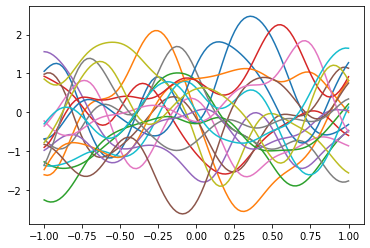

In [8]:
kernel = GPy.kern.RBF(input_dim=1, variance=1, lengthscale=0.2)
np.random.seed(seed=123)
N_sim = 100
x_sim = np.linspace(-1, 1, N_sim)
x_sim = x_sim[:, None]
mu = np.zeros(N_sim)
cov = kernel.K(x_sim, x_sim)
y_sim = np.random.multivariate_normal(mu, cov, size=20)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(20):
    ax.plot(x_sim[:], y_sim[i,:])
fig.savefig('output/fig1.png')

Widget Javascript not detected.  It may not be installed or enabled properly.
 /home/user/.local/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


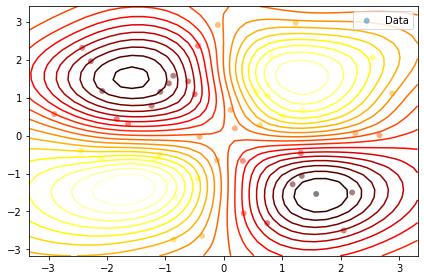

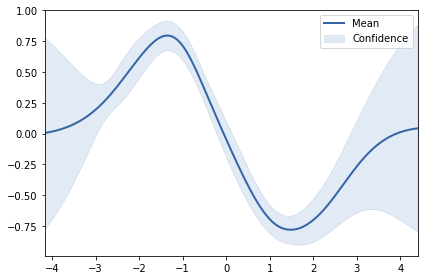

In [9]:
kernel = GPy.kern.Matern52(2, ARD=True)

np.random.seed(seed=123)
N = 50
X = np.random.uniform(-3.,3.,(N, 2))
Y = np.sin(X[:,0:1]) * np.sin(X[:,1:2]) + np.random.randn(N,1)*0.05

model = GPy.models.GPRegression(X, Y, kernel)
model.optimize(messages=True, max_iters=1e5)
model.plot()
plt.savefig('output/fig3.png')

model.plot(fixed_inputs=[(0, -1.0)], plot_data=False)
plt.savefig('output/fig3-slice.png')

## prediction
x_pred = np.array([np.linspace(-3, 3, 100), np.linspace(3, -3, 100)]).T
y_qua_pred = model.predict_quantiles(x_pred, quantiles=(2.5, 50, 97.5))[0]

 <ipython-input-15-e631ced5036c>:4: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 <ipython-input-15-e631ced5036c>:9: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


[[-28.8510499]] -17.915180302612246


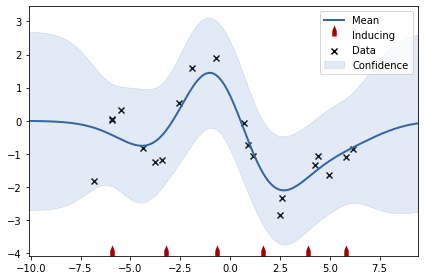

In [15]:
kernel = GPy.kern.RBF(1)

d = pd.read_csv('http://kasugano.sakura.ne.jp/images/2016/20161112/data-GPbook-Fig2_05.txt')
m_full = GPy.models.GPRegression(d.X[:, None], d.Y[:, None], kernel=kernel)
m_full.optimize()

Z = np.hstack((np.linspace(-6, -3, 3), np.linspace(3, 6, 3)))[:,None]
# Z = np.linspace(-6, 6, 12)[:, None]
m_sparse = GPy.models.SparseGPRegression(d.X[:, None], d.Y[:, None], Z=Z)
m_sparse.optimize()
m_sparse.plot()
plt.savefig('output/fig4.png')
print(m_sparse.log_likelihood(), m_full.log_likelihood())

 <ipython-input-16-335226bf36d4>:4: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
 /home/user/.local/lib/python3.8/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


AttributeError: 'dict' object has no attribute 'plot'

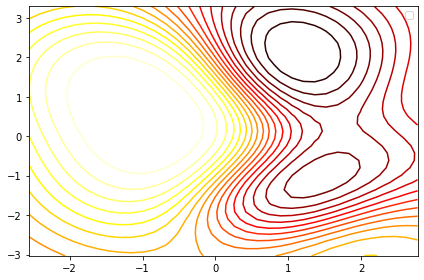

In [16]:
kernel = GPy.kern.RBF(2, ARD=True)

d = pd.read_csv('http://kasugano.sakura.ne.jp/images/2016/20161112/data-classification.txt')
model = GPy.models.GPClassification(d[['X1', 'X2']].values, d.Y[:, None])
model.optimize()

ax = model.plot(plot_data=False)
d0 = d[d.Y == 0]
d1 = d[d.Y == 1]
ax.plot(d0.X1, d0.X2, 'ro')
ax.plot(d1.X1, d1.X2, 'bo')
plt.savefig('output/fig5.png')

 <ipython-input-17-bd6c28d43cf4>:5: FutureWarning:Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


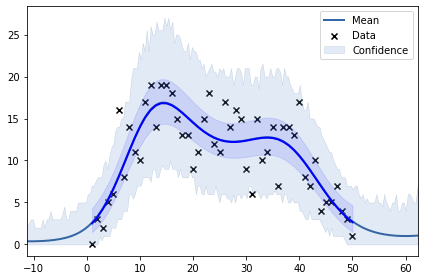

In [17]:
kernel = GPy.kern.RBF(1)

d = pd.read_csv('http://kasugano.sakura.ne.jp/images/2016/20161112/data-kubo11a.txt')

model = GPy.core.GP(X=np.linspace(1, 50, 50)[:,None], Y=d.Y[:,None], kernel=kernel,
    inference_method=GPy.inference.latent_function_inference.Laplace(),
    likelihood=GPy.likelihoods.Poisson())
model.optimize()
model.plot()
plt.savefig('output/fig6.png')

x_pred = np.linspace(1, 50, 50)[:, None]
f_mean, f_var = model._raw_predict(x_pred) # Predictive GP for log intensity mean and variance
f_upper, f_lower = f_mean + 2*np.sqrt(f_var), f_mean - 2.*np.sqrt(f_var)
plt.plot(x_pred, np.exp(f_mean), color='blue', lw=2)
plt.fill_between(x_pred[:,0], np.exp(f_lower[:,0]), np.exp(f_upper[:,0]), color='blue', alpha=.1)
plt.savefig('output/fig6-mean.png')


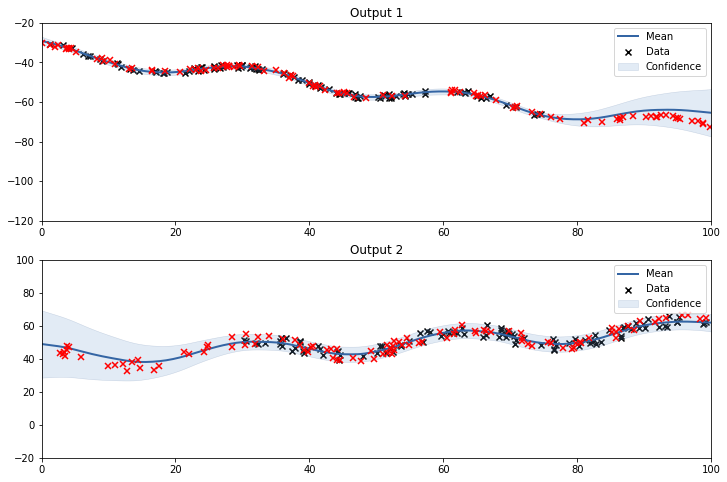

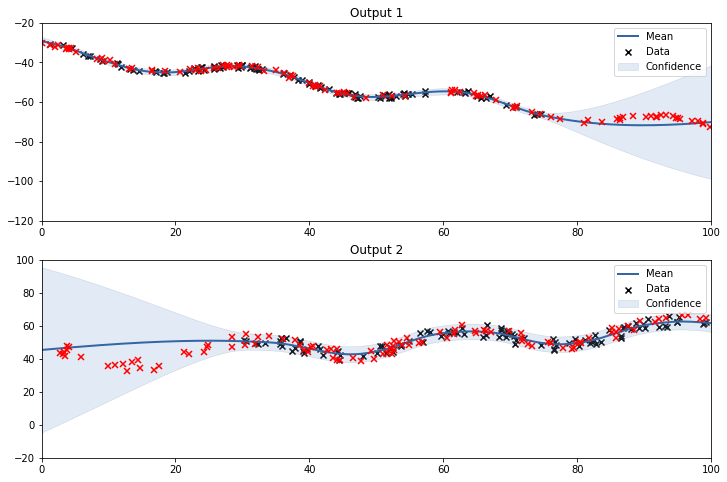

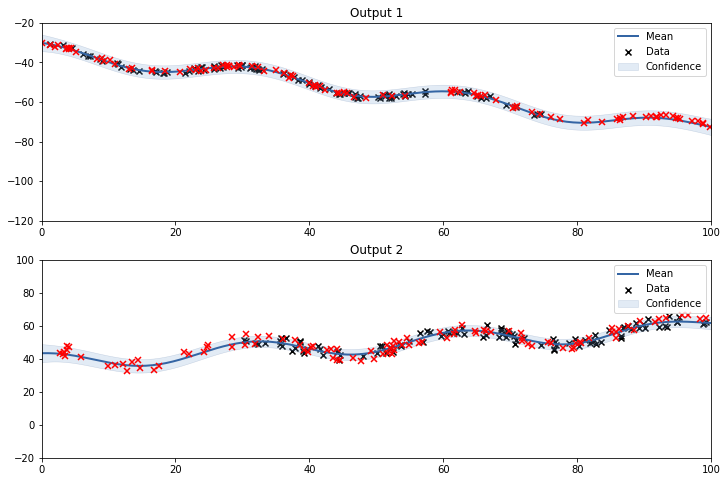

In [19]:
f_output1 = lambda x: 4*np.cos(x/5) - 0.4*x - 35 + np.random.rand(x.size) * 2
f_output2 = lambda x: 6*np.cos(x/5) + 0.2*x + 35 + np.random.rand(x.size) * 8

np.random.seed(seed=123)
X1 = np.random.rand(100)
X2 = np.random.rand(100)
X1 = X1*75
X2 = X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)

x_pred1 = np.random.rand(100)*100
x_pred2 = np.random.rand(100)*100
y_pred1 = f_output1(x_pred1)
y_pred2 = f_output2(x_pred2)

def plot_2outputs(m):
    fig = plt.figure(figsize=(12, 8))
    ax1 = fig.add_subplot(211)
    ax1.set_ylim([-120, -20])
    ax1.set_title('Output 1')
    m.plot(plot_limits=[0, 100], fixed_inputs=[(1, 0)], which_data_rows=slice(0, 100), ax=ax1)
    ax1.plot(x_pred1, y_pred1, 'rx', mew=1.5)
    ax2 = fig.add_subplot(212)
    ax2.set_ylim([-20, 100])
    ax2.set_title('Output 2')
    m.plot(plot_limits=[0, 100], fixed_inputs=[(1, 1)], which_data_rows=slice(100, 200), ax=ax2)
    ax2.plot(x_pred2, y_pred2, 'rx', mew=1.5)


K = GPy.kern.Matern32(1)
B = GPy.kern.Coregionalize(input_dim=1, output_dim=2)
kernel = K**B
model = GPy.models.GPCoregionalizedRegression(X_list=[X1[:, None],X2[:, None]], Y_list=[Y1[:, None],Y2[:, None]], kernel=kernel)

model['.*Mat32.var'].constrain_fixed(1)
model.optimize()
plot_2outputs(model)
plt.savefig('output/fig7a.png')

model['.*coregion.W'].constrain_fixed(0)
model.randomize()
model.optimize()
plot_2outputs(model)
plt.savefig('output/fig7b.png')


K1 = GPy.kern.RBF(1)
K2 = GPy.kern.Bias(1) + GPy.kern.Linear(1)
B1 = GPy.kern.Coregionalize(1, output_dim=2)
B2 = GPy.kern.Coregionalize(1, output_dim=2)
kernel = K1**B1 + K2**B2

X = np.vstack((np.concatenate([X1, X2]), np.hstack((np.zeros(100), np.ones(100))))).T
Y = np.hstack((Y1, Y2))[:, None]
model = GPy.models.GPRegression(X, Y, kernel)
model.optimize()
plot_2outputs(model)
plt.savefig('output/fig7c.png')


## prediction
x_pred = np.arange(100, 110)[:, None]
x_pred = np.hstack([x_pred, np.ones_like(x_pred)])
output_index_pred = {'output_index':x_pred[:,1:].astype(int)}
y_pred = model.predict(x_pred, Y_metadata=output_index_pred)

In [23]:
d = spio.loadmat('input/3Class.mat')
X = d['DataTrn']
X -= X.mean(0)
L = d['DataTrnLbls'].nonzero()[1]
input_dim = 2 # How many latent dimensions to use

kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Bias(input_dim) + GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim)
model = GPy.models.BayesianGPLVM(X, input_dim, kernel=kernel, num_inducing=30)
model.optimize(messages=True, max_iters=5e3)
model.plot_latent(labels=L)
plt.savefig('output/fig8.png')


FileNotFoundError: [Errno 2] No such file or directory: 'input/3Class.mat'

In [214]:
#n次元中の中心を決める
cluster_centers = center_std*np.random.randn(real_cluster_number,initial_data_dim)
distribution = data_std*np.random.randn(N_data_one_cluster,real_cluster_number,initial_data_dim)
distribution.shape,np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0).shape
X_data = distribution+np.repeat(cluster_centers[None,:],N_data_one_cluster,axis=0)
ts =np.repeat(np.arange(real_cluster_number),N_data_one_cluster)

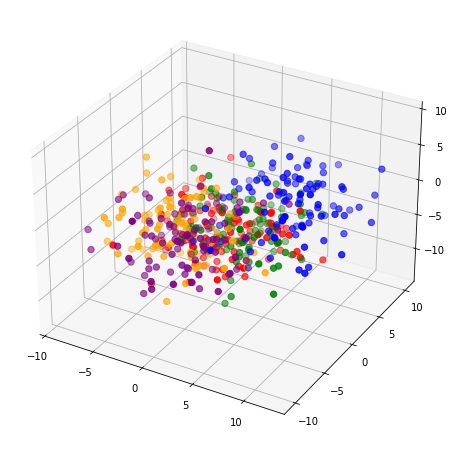

In [215]:
# Figureを追加
fig = plt.figure(figsize = (8, 8))
# 3DAxesを追加
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data[:,0,0], X_data[:,0,1], X_data[:,0,2], s = 40, c = "blue")
ax.scatter(X_data[:,1,0], X_data[:,1,1], X_data[:,1,2], s = 40, c = "red")
ax.scatter(X_data[:,2,0], X_data[:,2,1], X_data[:,2,2], s = 40, c = "green")
ax.scatter(X_data[:,3,0], X_data[:,3,1], X_data[:,3,2], s = 40, c = "purple")
ax.scatter(X_data[:,4,0], X_data[:,4,1], X_data[:,4,2], s = 40, c = "orange")

In [216]:
X_data_concat = X_data[:,0,:]
for i in range(1,X_data.shape[1]):
    X_data_concat = np.concatenate([X_data_concat,X_data[:,i,:]],axis=0)
X_data_concat.shape

(500, 10)

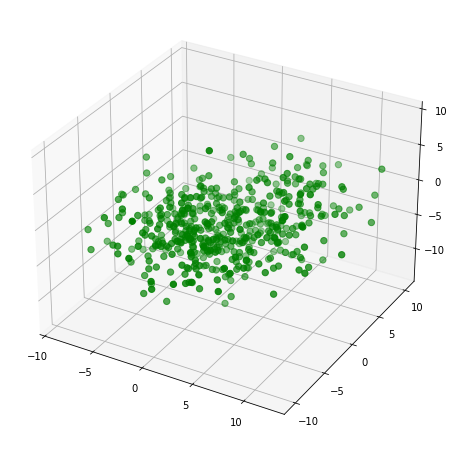

In [217]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_data_concat[:,0], X_data_concat[:,1], X_data_concat[:,2], s = 40, c = "green")
plt.show()

In [218]:
random_label = np.random.permutation(np.arange(X_data_concat.shape[0]))
X_2d_p_data = X_data_concat[random_label]
ts_p_data = ts[random_label]

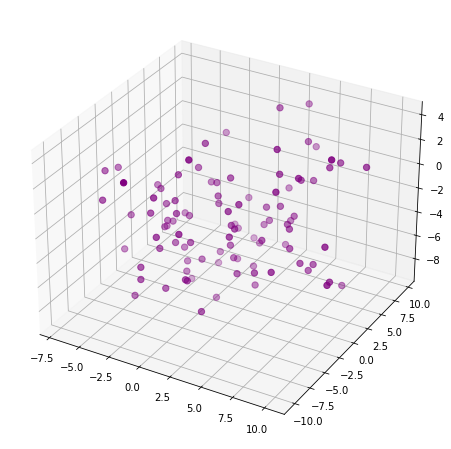

In [219]:
fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_2d_p_data[:100,0], X_2d_p_data[:100,1], X_2d_p_data[:100,2], s = 40, c = "purple")
plt.show()

In [220]:
X_2d_p_data.shape,X_2d_p_data.mean(),X_2d_p_data.var()
normalized_observed_data = (X_2d_p_data-X_2d_p_data.mean(axis=0))/X_2d_p_data.std(axis=0)

Widget Javascript not detected.  It may not be installed or enabled properly.


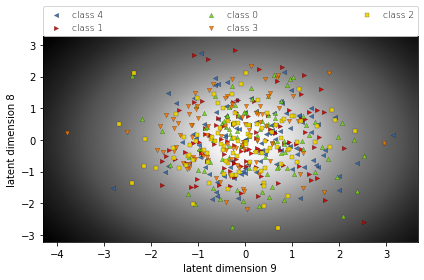

In [224]:
input_dim =10
kernel = GPy.kern.RBF(input_dim, ARD=True) + GPy.kern.Bias(input_dim) + GPy.kern.Linear(input_dim) + GPy.kern.White(input_dim)
model = GPy.models.GPLVM(normalized_observed_data, input_dim=input_dim,kernel=kernel)
model.optimize(messages=True, max_iters=1e3)
model.plot_latent(labels=ts_p_data)
plt.savefig("output/gplvm.png")


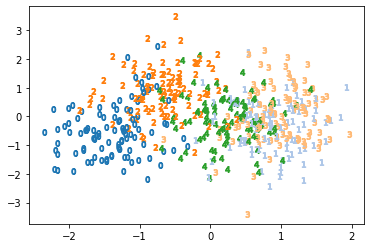

In [242]:
model.X.shape
cm = plt.cm.get_cmap('tab20')
for p,l in zip(model.X,ts_p_data):
    plt.scatter(p[0],p[3],marker="${}$".format(l),color=cm.colors[l])

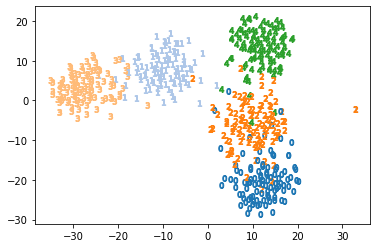

In [223]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
for p,l in zip(points,ts_p_data):
    plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

In [243]:
def log_P_func(l_f,latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    cluster_data = latent_data_f[l_f]
    cluster_center = cluster_data.mean(axis=0)
    n_prime = len(l_f)
    mu_c = (n_prime*cluster_center+pre_beta_f*pre_mu_0_f)/(n_prime+pre_beta_f)
#    mu_c = n_prime*cluster_center
#    mu_c +=pre_beta_f*pre_mu_0_f
#    mu_c/=(n_prime+pre_beta_f)

    S_q_inv = S_0_inv_f + n_prime*np.cov(cluster_data,rowvar=0,bias=1) + n_prime*pre_beta_f*np.outer(cluster_center-pre_mu_0_f,cluster_center-pre_mu_0_f)/(n_prime + pre_beta_f)
    S_r_inv = S_q_inv + (n_prime + pre_beta_f)*np.outer(latent_data_f[pick_up_number_f]-mu_c,latent_data_f[pick_up_number_f]-mu_c)/(n_prime + pre_beta_f+1)
    data_dim = latent_data_f[pick_up_number_f].shape[0]
    n_total = latent_data_f.shape[0]
#    print("n_prime={}".format(n_prime))
#    print("cluster_center={}".format(cluster_center))
#    print("mu_c={}".format(mu_c))
#    print("S_q_inv={}".format(S_q_inv))
#    print("S_r_inv={}".format(S_r_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

#    return S_r_inv,S_q_inv
#    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(S_r_inv)+0.5*(pre_nu_f + n_prime)*np.log(S_q_inv)+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))
    return np.log(n_prime/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log((n_prime+pre_beta_f)/(n_prime+pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + n_prime +1)*np.log(np.linalg.det(S_r_inv))+0.5*(pre_nu_f + n_prime)*np.log(np.linalg.det(S_q_inv))+math.lgamma(0.5*(pre_nu_f+n_prime+1))-math.lgamma(0.5*(pre_nu_f+n_prime+1-data_dim))


def log_P_new_func(latent_data_f,pick_up_number_f,dirichlet_alpha_f,pre_nu_f,pre_beta_f,pre_mu_0_f,S_0_inv_f):

    picked_data = latent_data_f[pick_up_number_f]
    S_b_inv = S_0_inv_f + pre_beta_f*np.outer(picked_data-pre_mu_0_f,picked_data-pre_mu_0_f)/(pre_beta_f+1)
    data_dim = picked_data.shape[0]
    n_total = latent_data_f.shape[0]

#    print("S_0_inv={}".format(S_0_inv_f))
#    print("S_b_inv={}".format(S_b_inv))
#    print("data_dim={}".format(data_dim))
#    print("n_total={}".format(n_total))

    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(np.linalg.det(S_b_inv))+0.5*pre_nu_f*np.log(np.linalg.det(S_0_inv_f))+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))
#    return np.log(dirichlet_alpha_f/(n_total-1+dirichlet_alpha_f))+0.5*data_dim*np.log(pre_beta_f/(pre_beta_f+1)/math.pi) - 0.5*(pre_nu_f + 1)*np.log(S_b_inv)+0.5*pre_nu_f*np.log(S_0_inv_f)+math.lgamma(0.5*(pre_nu_f+1))-math.lgamma(0.5*(pre_nu_f+1-data_dim))

In [244]:
def sum_del_log_gamma(nu,n,dim):
    x=0
    for i in range(dim):
       x+= math.lgamma(0.5*(nu+n-i))-math.lgamma(0.5*(nu-i))
    return x

def log_P_total(list_list,latent_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    cluster_number = len(list_list)
    data_dim = latent_data[0].shape[0]
    n_total = latent_data.shape[0]

    log_P = cluster_number*np.log(dirichlet_alpha)-math.lgamma(dirichlet_alpha+n_total)+ math.lgamma(dirichlet_alpha)
    for l in list_list:
        number_in_cluster = len(l)
        data_l = latent_data[l]
        data_l_av = data_l.mean(axis=0)
        S_q_inv = S_0_inv + number_in_cluster*np.cov(data_l,rowvar=0,bias=1)+ number_in_cluster*pre_beta*np.outer(data_l_av-pre_mu_0,data_l_av-pre_mu_0)/(number_in_cluster+pre_beta)
#        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(S_q_inv) +0.5*pre_nu*np.log(S_0_inv)+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))
        log_P += math.lgamma(number_in_cluster) -0.5*(pre_nu+number_in_cluster)*np.log(np.linalg.det(S_q_inv)) +0.5*pre_nu*np.log(np.linalg.det(S_0_inv))+sum_del_log_gamma(pre_nu,number_in_cluster,data_dim)+0.5*data_dim*(np.log(pre_beta/(number_in_cluster+pre_beta))-number_in_cluster*np.log(math.pi))

    return log_P

In [245]:
def softmax(a):
    # 一番大きい値を取得
    c = np.max(a)
    # 各要素から一番大きな値を引く（オーバーフロー対策）
    exp_a = np.exp(a - c)
    sum_exp_a = np.sum(exp_a)
    # 要素の値/全体の要素の合計
    y = exp_a / sum_exp_a
    return y

In [246]:
def cluster_prob(list_list,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    for l in list_list:
        if pick_up_number in l:
            current_place = list_list.index(l)
            list_list[current_place].remove(pick_up_number)

    for x in list_list:
        if x == []:
#            disappearing_index = list_list.index(x)
            list_list.remove(x)

    log_P = np.empty(len(list_list)+1)
    for i, l in enumerate(list_list):
        log_P[i] = log_P_func(l,latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    log_P[len(list_list)] = log_P_new_func(latent_data,pick_up_number,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)

    return softmax(log_P)

In [247]:
def show_mean_cov(X_data,list_list):

    N_cluster = len(list_list)
    for i in range(N_cluster):
        X_0 = X_data[list_list[i]]
        print("--cluster{}--".format(i))
        print("N_member_{}={}".format(i,len(list_list[i])))
        print("Mean_{}={}".format(i,X_0.mean(axis=0)))
        print("Cov_{}=\n{}\n".format(i,np.cov(X_0,rowvar=0,bias=1)))


In [248]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_with_centers(mus_numpy,ts_numpy,list_list):
    for p,l in zip(mus_numpy,ts_numpy):
        plt.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    N_cluster = len(list_list)
    X_mean = np.empty([N_cluster,2])
    for i in range(N_cluster):
        X_mean[i] = mus_numpy[list_list[i]].mean(axis=0)
    for p in X_mean:
        plt.scatter(p[0],p[1],facecolors='none',edgecolors='red',s=200)
    for i, p in enumerate(X_mean):
        plt.scatter(p[0],p[1],marker="${}$".format(i),color='black',s=50)
    plt.show()

In [249]:
cm = plt.cm.get_cmap('tab20')
def drawpoints_3d(mus_numpy,ts_numpy):
    fig = plt.figure(figsize = (8, 8))
    ax = fig.add_subplot(111, projection='3d')
#    for i in range(len(list_list)):
#        ax.scatter(mus_numpy[list_list[i],0], mus_numpy[list_list[i],1], mus_numpy[list_list[i],2], s = 40, color=cm.colors[i])
    for p,l in zip(mus_numpy,ts_numpy):
        ax.scatter(p[0],p[1],marker="${}$".format(l),color=cm.colors[l])

    plt.show()

In [250]:
def clustering_index(list_list):

    total_N =0
    for l in list_list:
        total_N += len(l)

    ts = np.empty(total_N)
    for i, l in enumerate(list_list):
        ts[l] = i

    return ts.astype(int)

In [251]:
def one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):
    for pick_up_index in range(X_data.shape[0]):
        probability = cluster_prob(list_list,X_data,pick_up_index,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        selected_cluster = np.random.choice(a=np.arange(len(list_list)+1),size=1,p=probability).item()
        if selected_cluster == len(list_list):
            list_list.append([pick_up_index])
        else:
            list_list[selected_cluster].append(pick_up_index)

In [252]:
def clustering(epoch_max,stopping_epoch,list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv):

    best_log_P = log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
    best_list_list =  copy.deepcopy(list_list)
    k=0
    for i in range(epoch_max):
        one_epoch(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
        print("i={},k={},N_cluster={},clustering_numbers = {}".format(i,k,len(list_list),[len(l) for l in list_list]))
        k+=1
        if log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv) > best_log_P:
            best_log_P=log_P_total(list_list,X_data,dirichlet_alpha,pre_nu,pre_beta,pre_mu_0,S_0_inv)
            best_list_list =  copy.deepcopy(list_list)
            print("best value is updated. best_log_p={},N_cluster={}".format(best_log_P,len(best_list_list)))
            k=0
        if k == stopping_epoch:
            break

    return best_log_P,best_list_list,i




In [279]:
dirichlet_alpha_g = 1.
pre_nu_g =15.
pre_beta_g =0.1
pre_mu_0_g =np.mean(points,axis=0)
S_0_inv_g = 1*np.cov(points,rowvar=0,bias=1)
#S_0_inv_g = 20.*np.eye(initial_data_dim)

#grouping = [list(range(X_2d_p_data.shape[0]))]
grouping = []
for i in range(50):
    grouping.append([m for m in range(10*i,10*i+10)])
grouping_temp = copy.deepcopy(grouping)
#grouping_temp

In [281]:

dirichlet_alpha_g = 0.01
best_log_prob,best_labeling,best_time=clustering(500,100,grouping_temp,points,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#one_epoch(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
#len(grouping_temp),log_P_total(grouping_temp,X_2d_p_data,dirichlet_alpha_g,pre_nu_g,pre_beta_g,pre_mu_0_g,S_0_inv_g)
len(best_labeling),best_log_prob,best_time,[len(l) for l in best_labeling]

i=0,k=0,N_cluster=11,clustering_numbers = [102, 100, 94, 94, 41, 44, 12, 2, 7, 1, 3]
i=1,k=1,N_cluster=10,clustering_numbers = [99, 101, 99, 92, 44, 42, 14, 2, 5, 2]
best value is updated. best_log_p=-3850.4389704280666,N_cluster=10
i=2,k=0,N_cluster=10,clustering_numbers = [98, 104, 98, 89, 47, 43, 11, 2, 7, 1]
i=3,k=1,N_cluster=9,clustering_numbers = [102, 114, 94, 90, 50, 39, 8, 2, 1]
best value is updated. best_log_p=-3813.6198552650185,N_cluster=9
i=4,k=0,N_cluster=8,clustering_numbers = [101, 113, 99, 88, 52, 32, 13, 2]
best value is updated. best_log_p=-3805.077055308051,N_cluster=8
i=5,k=0,N_cluster=8,clustering_numbers = [105, 108, 103, 88, 60, 24, 10, 2]
i=6,k=1,N_cluster=8,clustering_numbers = [98, 104, 102, 93, 72, 22, 7, 2]
best value is updated. best_log_p=-3785.435696611591,N_cluster=8
i=7,k=0,N_cluster=8,clustering_numbers = [98, 109, 99, 91, 64, 25, 12, 2]
best value is updated. best_log_p=-3781.711533807811,N_cluster=8
i=8,k=0,N_cluster=8,clustering_numbers = [97, 116

(6, -3701.842545259483, 250, [97, 105, 100, 95, 101, 2])

In [282]:
#show_mean_cov(X_2d_p_data,grouping_temp)
show_mean_cov(X_2d_p_data,best_labeling)

--cluster0--
N_member_0=97
Mean_0=[ -0.74661814  -3.81623826  -2.94932498  -4.66343711   2.00860588
  -1.23502266 -10.20866618   0.70965089   3.54142743  -3.19487125]
Cov_0=
[[ 8.45315265e+00  2.55197409e-01  4.06618288e-01 -1.92700880e-01
   7.93077451e-01  5.10044127e-01 -1.60748865e+00  9.06968704e-01
  -4.44859376e-01  5.14241536e-01]
 [ 2.55197409e-01  8.36985436e+00  6.77395255e-01 -4.73717639e-01
  -9.98975074e-01 -2.30398652e-01  5.34912760e-01  6.02859115e-03
   5.77774168e-01 -1.05194693e+00]
 [ 4.06618288e-01  6.77395255e-01  9.37466535e+00  7.16361590e-01
  -1.10028463e+00  2.23090243e-01  5.12529838e-01 -7.99157541e-02
   1.00811324e+00  2.20908207e+00]
 [-1.92700880e-01 -4.73717639e-01  7.16361590e-01  8.38056711e+00
   1.18367398e+00 -4.39450065e-01  6.86876474e-01  4.34220098e-01
  -2.98330046e-02 -3.06877326e-01]
 [ 7.93077451e-01 -9.98975074e-01 -1.10028463e+00  1.18367398e+00
   9.96286183e+00 -7.70303313e-01  3.64860724e-02  1.51010301e+00
   1.12796599e+00  1.81959

In [283]:
ts_p_data[best_labeling[0]]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3])

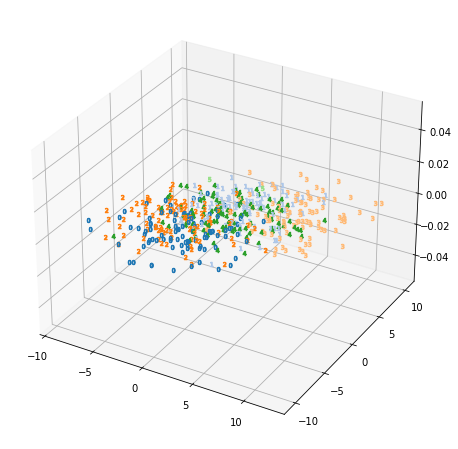

In [284]:
drawpoints_3d(X_2d_p_data,clustering_index(best_labeling))

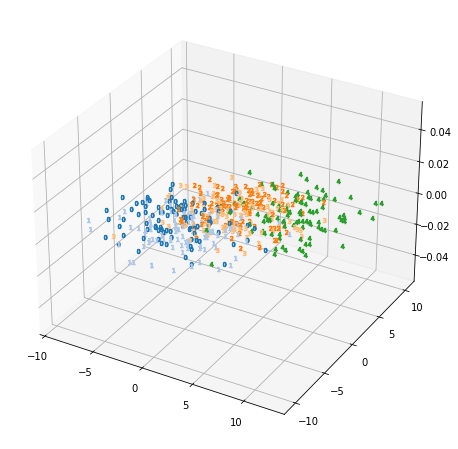

In [285]:
kmeans_model = KMeans(n_clusters=real_cluster_number, random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,kmeans_model.labels_)

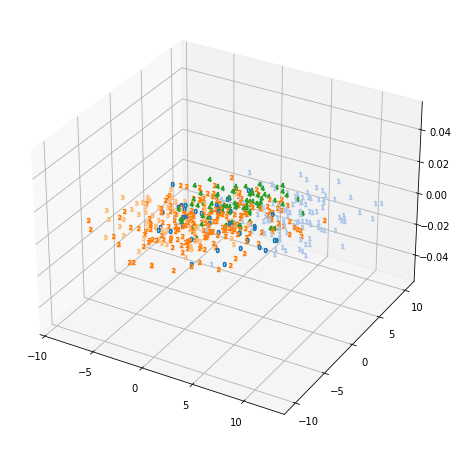

In [286]:
gauss_model = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(X_2d_p_data)
drawpoints_3d(X_2d_p_data,gauss_model.predict(X_2d_p_data))

In [287]:
points = TSNE(n_components=2,random_state=0).fit_transform(X_2d_p_data)
drawpoints_with_centers(points,clustering_index(ts_p_data),best_labeling)


TypeError: object of type 'numpy.int64' has no len()

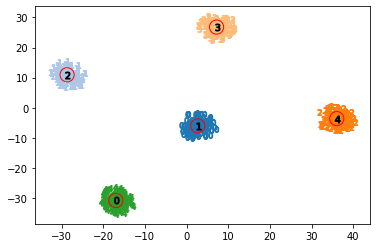

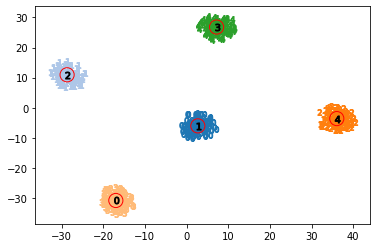

In [1074]:
kmeans_model_afterTNSE = KMeans(n_clusters=real_cluster_number, random_state=1).fit(points)
drawpoints_with_centers(points,kmeans_model_afterTNSE.labels_,best_labeling)
drawpoints_with_centers(points,kmeans_model.labels_,best_labeling)

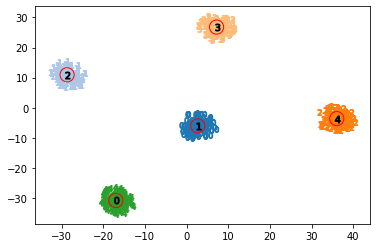

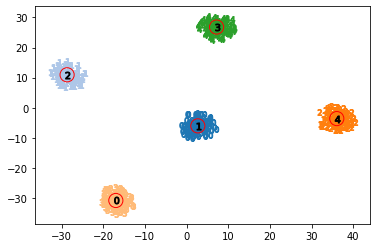

In [1075]:
gauss_model_afterTNSE  = GaussianMixture(n_components=real_cluster_number,covariance_type='full',random_state=1).fit(points)
drawpoints_with_centers(points,gauss_model_afterTNSE.predict(points),best_labeling)
drawpoints_with_centers(points,gauss_model.predict(X_2d_p_data),best_labeling)